In [2]:
%pip install pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/38.6 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.6 MB 9.3 MB/s eta 0:00:05
    --------------------------------------- 0.7/38.6 MB 8.2 MB/s eta 0:00:05
   - -------------------------------------- 1.0/38.6 MB 7.9 MB/s eta 0:00:05
   - -------------------------------------- 1.3/38.6 MB 8.2 MB/s eta 0:00:05
   -- ------------------------------------- 2.0/38.6 MB 9.3 MB/s eta 0:00:04
   -- ------------------------------------- 2.6/38.6 MB 9.7 MB/s eta 0:00:04
   --- ------------------------------------ 3.0/38.6 MB 9.5 MB/s eta 0:00:04
   --- ------------------------------------ 3.4/38.6 MB 9.3 MB/s eta 0:00:04
   --- ------------------------------------ 3.8/38.6 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.2/38.6 MB 9.3 MB/s eta 0:00:04
   ---- ----------------------------------- 4.8/38.6 MB 9.5 MB/s eta 0:00:04
   ----- ---------------------------------- 5.3/38.6 MB 9.3 MB/s eta 0:00:04
   --

In [1]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt

C:\Users\Mrudula\AppData\Local\Temp\ipykernel_18204\183779410.py:4: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [2]:
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
#from skimage import io
from tqdm import tqdm

In [3]:
mydir = 'CoffeeBeanQualityData/train/'

In [4]:
categories = ['Green','Light','Medium','Dark']
data =[]
for i in categories:
  folder_path = os.path.join(mydir,i)
  if(i=='Green'):
    label = 0
  elif(i=='Light'):
    label = 1
  elif(i=='Medium'):
    label = 2
  else:
    label = 3
  for j in os.listdir(folder_path):
    img_path = os.path.join(folder_path, j)
    img = cv2.imread(img_path)
    img = cv2.resize(img,(224, 224))
    data.append([img,label])

In [5]:
import random
random.shuffle(data)

In [6]:
x=[]
y=[]

for i in data:
  x.append(i[0])
  y.append(i[1])

In [7]:
y = np.array(y)
x = np.array(x)

Load Images in Data Generator

In [8]:
image_size = (224, 224)
batch_size = 64
datagen = ImageDataGenerator(
            rescale = 1./255,
            rotation_range=45,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.25,
            zoom_range=0.25,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='reflect',
            validation_split = 0.1)

In [9]:
train_ds = datagen.flow_from_directory(mydir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = datagen.flow_from_directory(mydir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")

Found 1080 images belonging to 4 classes.
Found 120 images belonging to 4 classes.


In [10]:
train_ds.class_indices

{'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

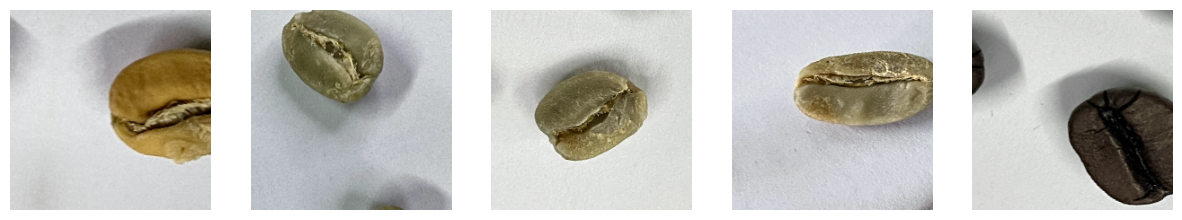

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

In [11]:
from keras import applications

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout

In [13]:
res_base = applications.ResNet152V2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
res_base.trainable = False

inputs = Input(shape=(224, 224, 3))

In [ ]:
x = res_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation = 'sigmoid')(x)
res_model = Model(inputs, outputs)

res_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

epochs = 25
hist = res_model.fit(train_ds, epochs=epochs, validation_data=val_ds)
res_model.save('resnet.hdf5')

C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25


C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\backend\tensorflow\nn.py:636: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - categorical_accuracy: 0.4631 - loss: 1.8514 

C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 260s 14s/step - categorical_accuracy: 0.4709 - loss: 1.8209 - val_categorical_accuracy: 0.7667 - val_loss: 0.5639
Epoch 2/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 215s 13s/step - categorical_accuracy: 0.8124 - loss: 0.5195 - val_categorical_accuracy: 0.9500 - val_loss: 0.1854
Epoch 3/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 217s 13s/step - categorical_accuracy: 0.8999 - loss: 0.2647 - val_categorical_accuracy: 0.9417 - val_loss: 0.2212
Epoch 4/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 218s 13s/step - categorical_accuracy: 0.8886 - loss: 0.2763 - val_categorical_accuracy: 0.9083 - val_loss: 0.2347
Epoch 5/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 239s 14s/step - categorical_accuracy: 0.9197 - loss: 0.2286 - val_categorical_accuracy: 0.9333 - val_loss: 0.1628
Epoch 6/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 247s 15s/step - categorical_accuracy: 0.9259 - loss: 0.2075 - val_categorical_accuracy: 0.9583 - val_loss: 0.1185
Epoch 7/25
17/17 ━━━━━━━━━━━━━━━━━━━━ 248s 14s/step - categorical_accuracy: 0.9397 - loss: 0.1537 -

In [15]:
for idx in train_ds:
    print(idx[0].shape)
    print(idx[1].shape)
    break
len(train_ds)

(64, 224, 224, 3)
(64, 4)


17

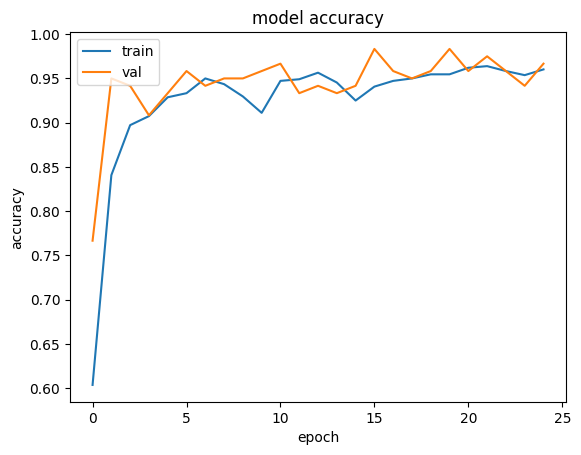

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
plt.plot(hist.history['categorical_accuracy'])
plt.plot(hist.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

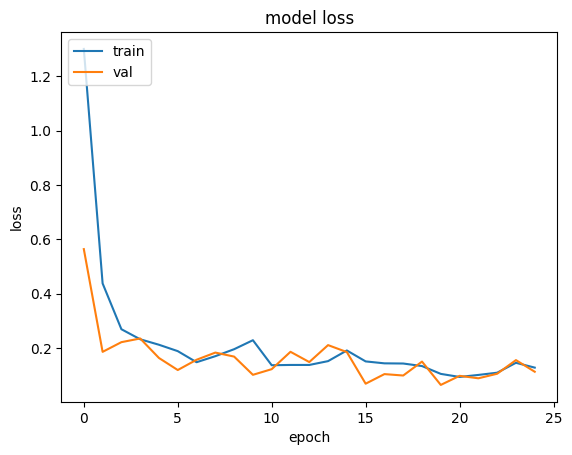

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
my_testdir = 'CoffeeBeanQualityData/test/'

In [19]:
test_ds = datagen.flow_from_directory(my_testdir,
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",
                                      shuffle=False )

Found 360 images belonging to 4 classes.


In [ ]:
from tensorflow import keras

loaded_model = keras.models.load_model('resnet.hdf5')

pred_probabilities = loaded_model.predict(test_ds)

# Convert predicted probabilities to class labels
pred_labels = np.argmax(pred_probabilities, axis=1)

# Print the predicted labels
print(pred_labels)

C:\Users\Mrudula\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 71s 11s/step
[0 3 0 0 0 3 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 0 3 0 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3
 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 0
 3 3 3 3 3 3 3 3 3 3 3 3 3 0 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
true_labels = test_ds.classes

# Get class indices mapping from the test data generator
class_indices = test_ds.class_indices

# Generate classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_indices, output_dict=True)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)

# Print classification report with accuracy
print("Classification Report:")
print(class_report)
print("Accuracy:", accuracy)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

# Print confusion matrix
print("\nConfusion Matrix:")
print(conf_matrix)

Classification Report:
{'Dark': {'precision': 0.9247311827956989, 'recall': 0.9555555555555556, 'f1-score': 0.9398907103825137, 'support': 90.0}, 'Green': {'precision': 1.0, 'recall': 0.9777777777777777, 'f1-score': 0.9887640449438202, 'support': 90.0}, 'Light': {'precision': 0.9782608695652174, 'recall': 1.0, 'f1-score': 0.989010989010989, 'support': 90.0}, 'Medium': {'precision': 0.9540229885057471, 'recall': 0.9222222222222223, 'f1-score': 0.9378531073446328, 'support': 90.0}, 'accuracy': 0.9638888888888889, 'macro avg': {'precision': 0.9642537602166659, 'recall': 0.963888888888889, 'f1-score': 0.9638797129204889, 'support': 360.0}, 'weighted avg': {'precision': 0.9642537602166656, 'recall': 0.9638888888888889, 'f1-score': 0.963879712920489, 'support': 360.0}}
Accuracy: 0.9638888888888889

Confusion Matrix:
[[86  0  0  4]
 [ 0 88  2  0]
 [ 0  0 90  0]
 [ 7  0  0 83]]


In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
class_report = classification_report(true_labels, pred_labels, target_names=class_indices, output_dict=True)

# Calculate accuracy
accuracy = accuracy_score(true_labels, pred_labels)
print("Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=class_indices))



Classification Report:
              precision    recall  f1-score   support

        Dark       0.92      0.96      0.94        90
       Green       1.00      0.98      0.99        90
       Light       0.98      1.00      0.99        90
      Medium       0.95      0.92      0.94        90

    accuracy                           0.96       360
   macro avg       0.96      0.96      0.96       360
weighted avg       0.96      0.96      0.96       360



Classification Report:
Accuracy: 0.9638888888888889


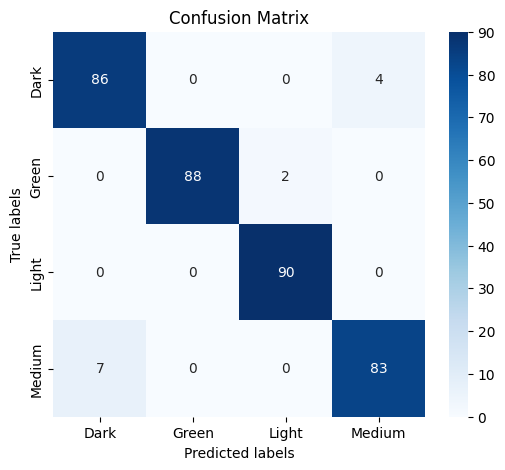

In [23]:
print("Classification Report:")
print("Accuracy:", accuracy)


conf_matrix = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix as heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [24]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    
    label_names = train_ds.class_indices
    dict_class = dict(zip(list(range(len(label_names))), label_names))
    clas = model.predict(image).argmax()
    name = dict_class[clas]
    #return clas
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

In [ ]:
incep_model = tf.keras.models.load_model('resnet.hdf5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
The given image is of 
Class: 2 
Species: Light


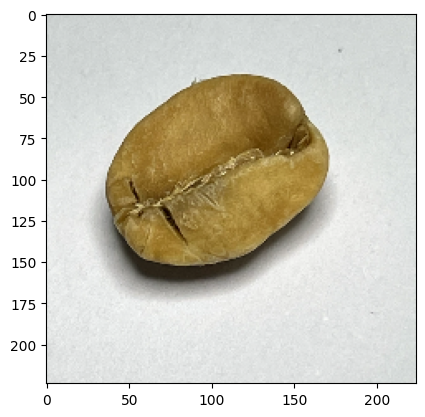

In [30]:
predictor(r'CoffeeBeanQualityData\test\Light\light (8).png', incep_model)

Frontend

In [5]:
%pip install streamlit

Note: you may need to restart the kernel to use updated packages.Defaulting to user installation because normal site-packages is not writeable



DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%%writefile app.py


import streamlit as st
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps

# Set the page layout to wide
st.set_page_config(layout="wide")

# Load the model once to improve performance
@st.cache_resource
def load_model():
    model = tf.keras.models.load_model('resnet.hdf5')
    return model

# Apply custom styling
st.markdown(
    """
    <style>
    .st-title {
        color: #3E2723;
        font-size: 40px;
        font-weight: bold;
    }
    .st-header {
        color: #6D4C41;
        font-size: 24px;
        font-weight: bold;
    }
    
    .st-success {
        font-size: 18px;
        color: #2e7d32;
        background-color: #a5d6a7;
        padding: 10px;
        border-radius: 5px;
    }
    .st-uploaded-image {
        border: 5px solid #6D4C41;
        border-radius: 10px;
        box-shadow: 0 4px 8px rgba(0,0,0,0.2);
    }
    
    </style>
    """,
    unsafe_allow_html=True
)

# Sidebar for user input selection
st.sidebar.title("Choose Input Source")
input_method = st.sidebar.radio("Select an input method:", ("Upload Image", "Use Camera", "Input Image URL"))

# Title of the app
st.title("Coffee Bean Quality Prediction App")

col1, col2 = st.columns([2, 1])  # Adjust the column ratios as needed

# Column 1: Text
with col1:
   
    st.markdown( """ 
                <div class="col1-box"> 
                <h2>Welcome to the Coffee Bean Quality Prediction App! ☕</h2> 
                <p> Coffee is more than just a drink – it's a passion, an experience, and for many, a daily ritual that starts 
                the day with energy and warmth. Whether you enjoy it bold, smooth, or with a touch of cream, the quality of 
                your coffee beans plays a significant role in how your cup of coffee tastes. This app uses a powerful machine 
                learning model to analyze your coffee beans and predict their quality, helping you get the best brew every time. 
                Factors like color, shape, and size influence the aroma, flavor, and smoothness of your coffee – and we're here to 
                help you determine which beans are ready for your perfect cup. Simply upload an image of your coffee beans, and let 
                the app provide an accurate prediction of their quality. Remember, great coffee starts with great beans! 
                </p> </div> """
                , unsafe_allow_html=True )
  
# Column 2: Image
with col2:
    
    # You can replace the image URL with your local file or a web image URL
    st.image("images/coffee_beans_image.png", caption="Fresh Coffee Beans", use_container_width=True)


# Instructions for the user
st.header("Upload an Image of Coffee Beans to Predict Their Quality")
st.write("This app uses a trained model to classify coffee beans into different quality categories based on an image you upload. Please upload a clear image.")

# Function to preprocess and predict image quality
def import_and_predict(image_data, model):
    size = (224, 224)
    image = ImageOps.fit(image_data, size)
    img = np.array(image, dtype='float32') / 255.0
    img_reshape = img[np.newaxis, ...]
    prediction = model.predict(img_reshape)
    return prediction

# Image upload section
if input_method == "Upload Image":
    file = st.file_uploader("Choose a Coffee Bean Image", type=["jpg", "png"])

    if file is not None:
        image = Image.open(file)
        # Display the uploaded image with better styling
        st.image(image, use_column_width=True, caption="Uploaded Image", output_format="PNG", class_="st-uploaded-image")

        # Prediction logic
        model = load_model()
        predictions = import_and_predict(image, model)
        class_names = ['Dark', 'Green', 'Light', 'Medium']
        predicted_class = class_names[np.argmax(predictions)]
        confidence = round(np.max(predictions), 2)

        # Display the prediction results with improved styling
        result_message = f"This image most likely is: **{predicted_class}** with a confidence of **{confidence*100}%**"
        st.success(result_message)

# Camera input section
elif input_method == "Use Camera":
    # Use camera input feature
    img = st.camera_input("Capture a Coffee Bean Image")

    if img:
        image = Image.open(img)
        # Display the captured image with better styling
        st.image(image, use_column_width=True, caption="Captured Image", output_format="PNG", class_="st-uploaded-image")

        # Prediction logic
        model = load_model()
        predictions = import_and_predict(image, model)
        class_names = ['Dark', 'Green', 'Light', 'Medium']
        predicted_class = class_names[np.argmax(predictions)]
        confidence = round(np.max(predictions), 2)

        # Display the prediction results with improved styling
        result_message = f"This image most likely is: **{predicted_class}** with a confidence of **{confidence*100}%**"
        st.success(result_message)

# Image URL input section
elif input_method == "Input Image URL":
    image_url = st.text_input("Enter Image URL:")

    if image_url:
        image = Image.open(image_url)
        # Display the image from URL
        st.image(image, use_column_width=True, caption="Image from URL", output_format="PNG", class_="st-uploaded-image")

        # Prediction logic
        model = load_model()
        predictions = import_and_predict(image, model)
        class_names = ['Dark', 'Green', 'Light', 'Medium']
        predicted_class = class_names[np.argmax(predictions)]
        confidence = round(np.max(predictions), 2)

        # Display the prediction results with improved styling
        result_message = f"This image most likely is: **{predicted_class}** with a confidence of **{confidence*100}%**"
        st.success(result_message)


Overwriting app.py
